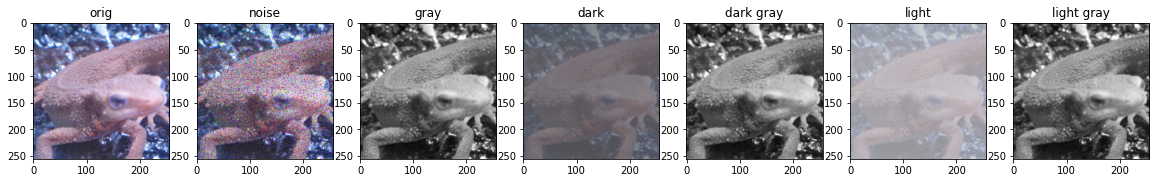

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256.png')
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_noise.png')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_light.png')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(20, 4))
plt.subplot(1, 7, 1); plt.imshow(img_orig); plt.title('orig')
plt.subplot(1, 7, 2); plt.imshow(img_noise); plt.title('noise')
plt.subplot(1, 7, 3); plt.imshow(img_gray, cmap='gray'); plt.title('gray')
plt.subplot(1, 7, 4); plt.imshow(img_dark);  plt.title('dark')
plt.subplot(1, 7, 5); plt.imshow(img_dark_gray, cmap='gray'); plt.title('dark gray')
plt.subplot(1, 7, 6); plt.imshow(img_light);  plt.title('light')
plt.subplot(1, 7, 7); plt.imshow(img_light_gray, cmap='gray'); plt.title('light gray')
plt.show()

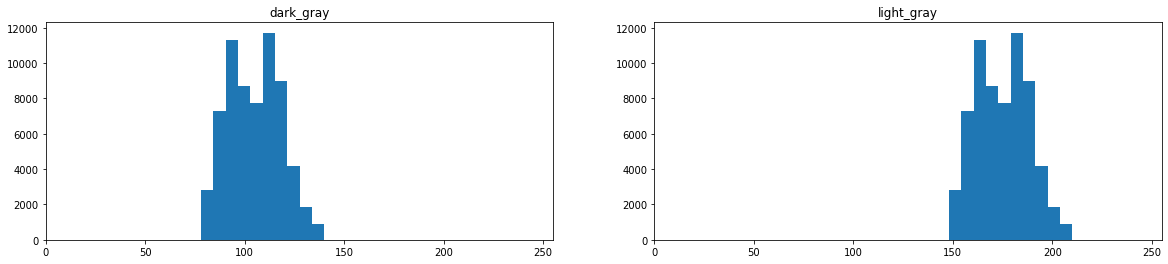

In [2]:
# 以外に面白いのが、暗い画像も明るい画像もグレースケールにすると結構近い色になること
# ヒストグラムはたしかに偏っている　
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark_gray.ravel()); plt.xlim(0, 255); plt.title('dark_gray')
plt.subplot(1, 2, 2); plt.hist(img_light_gray.ravel()); plt.xlim(0, 255); plt.title('light_gray')
plt.show()

### Q.21 ヒストグラム正規化, Histogram normalization
ヒストグラムは偏ることがある。 例えば、0に近い画素が多ければ画像は全体的に暗く、255に近い画素が多ければ画像は明るくなる。 ヒストグラムが局所的に偏っていることをダイナミックレンジが狭いなどと表現する。 そのため画像を人の目に見やすくするために、ヒストグラムを正規化したり平坦化したりなどの処理が必要である。

このヒストグラム正規化は濃度階調変換(gray-scale transformation) と呼ばれ、[c,d]の画素値を持つ画像を[a,b]のレンジに変換する場合は次式で実現できる。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_21_30/images/hist_norm_equ.png" width="400"/>

今回はimori_256x256_dark.pngを[0, 255]のレンジにそれぞれ変換する。

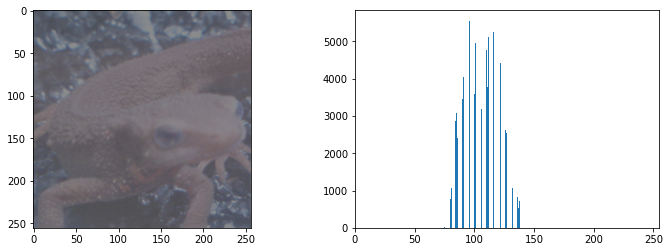

In [3]:
# 元々のヒストグラムはこれ　　明らかに画像は暗く、ヒストグラムも偏っている
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.imshow(img_dark);
plt.subplot(1, 2, 2); plt.hist(img_dark.ravel(), bins=255);
plt.xlim([0, 255]); plt.show()

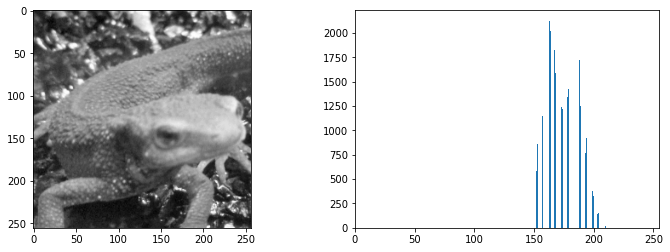

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.imshow(img_light_gray, cmap='gray');
plt.subplot(1, 2, 2); plt.hist(img_light_gray.ravel(), bins=255);
plt.xlim([0, 255]); plt.show()

In [5]:
# 実際に画素の最小最大を調べると、この範囲にしかピクセル値がない
img_dark.min(), img_dark.max()

(71, 140)

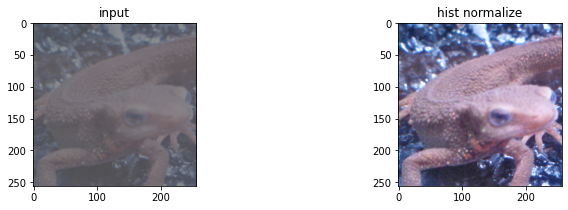

In [6]:
# answer
def hist_normalize(img, a, b):
    c, d = img.min(), img.max()
    # if c <= xin < d
    out = (b - a) / (d - c) * (img - c) + a
    # if xin < c
    out[img < c] = a
    # if xin > d
    out[img > d] = b
    return np.clip(out, 0, 255).astype(np.uint8)

img_dark_hist_norm = hist_normalize(img_dark, a=0, b=255) # smoothing filtering

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1); plt.title('input'); plt.imshow(img_dark)
plt.subplot(1, 2, 2); plt.title('hist normalize'); plt.imshow(img_dark_hist_norm)
plt.show()

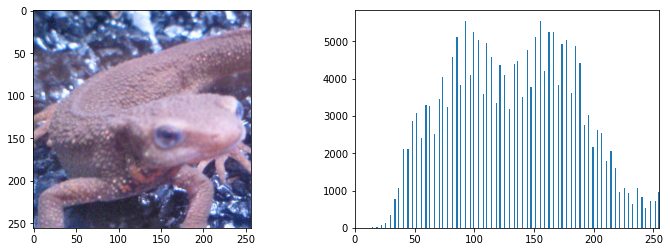

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.imshow(img_dark_hist_norm);
plt.subplot(1, 2, 2); plt.hist(img_dark_hist_norm.ravel(), bins=255);
plt.xlim([0, 255]); plt.show()

### Q.22 ヒストグラムのスケーリングとシフト, Histogram scaling and shift

ヒストグラムの平均値をm0=128、標準偏差をs0=50になるように操作せよ。

これはヒストグラムのダイナミックレンジを変更するのではなく、ヒストグラムを平坦に変更する操作である。

もともとが平均値  、標準偏差  、のヒストグラムを平均値m, 標準偏差sに変更するには、次式によって変換する。

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_21_30/images/hist_norm_equ.png" width="400"/>

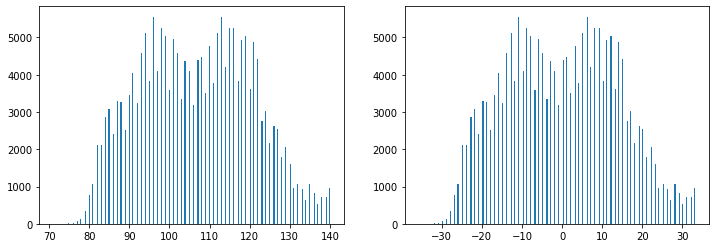

In [8]:
# 原理 1
# xin - m0 は画素の平均を0にする操作
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255)
plt.subplot(1, 2, 2); plt.hist((img_dark - img_dark.mean()).ravel(), bins=255)
plt.show()

In [9]:
img_dark.std()

14.010876302431814

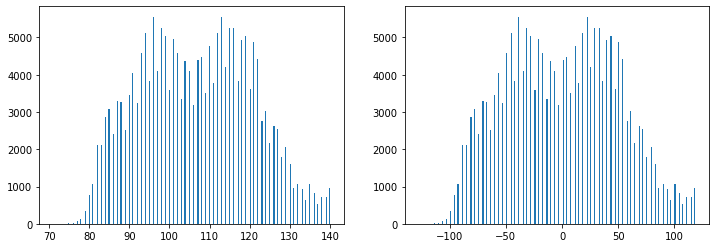

In [10]:
# 原理 2
# s / s0 は画素のstdを1にした後、希望の値にスケーリングする操作
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255)
plt.subplot(1, 2, 2); plt.hist( 50 / img_dark.std() * (img_dark - img_dark.mean()).ravel(), bins=255)
plt.show()

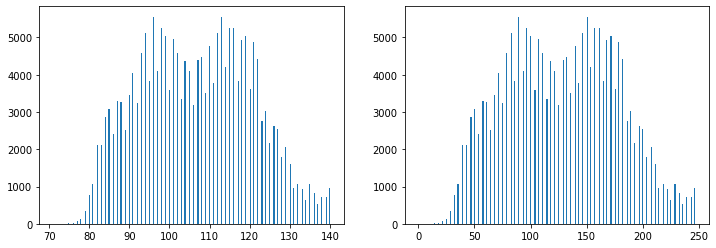

In [11]:
# 原理 3
# + m は希望のmeanにシフトする操作
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255)
plt.subplot(1, 2, 2); plt.hist( 50 / img_dark.std() * (img_dark - img_dark.mean()).ravel() + 128, bins=255)
plt.show()

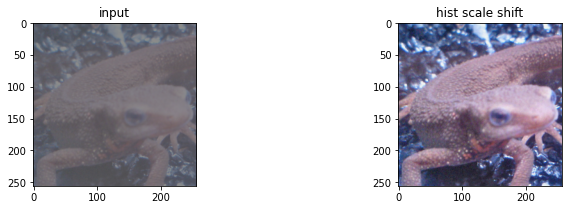

In [12]:
# answer
def hist_scaleshift(img, m, s):
    m0, s0 = img.mean(), img.std()
    out = s / s0 * (img - m0) + m
    return np.clip(out, 0, 255).astype(np.uint8)

img_dark_hist_scaleshift = hist_scaleshift(img_dark, m=128, s=50) # smoothing filtering

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1); plt.title('input'); plt.imshow(img_dark)
plt.subplot(1, 2, 2); plt.title('hist scale shift'); plt.imshow(img_dark_hist_scaleshift)
plt.show()

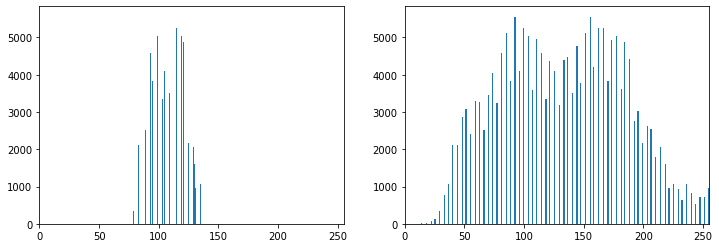

In [13]:
# histogram をみると画素が分散した
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255); plt.xlim([0, 255])
plt.subplot(1, 2, 2); plt.hist(img_dark_hist_norm.ravel(), bins=255); plt.xlim([0, 255])
plt.show()

### Q.23 ヒストグラム平坦化, Histogram equalization

ヒストグラム平坦化を実装せよ。

ヒストグラム平坦化とはヒストグラムを平坦に変更する操作であり、上記の平均値や標準偏差などを必要とせず、ヒストグラム値を均衡にする操作である。

画素がxのものは次式の変化でx'になる

S ... 画素の総数 (height x width x channel)、$x_{max}$ ... 画素値の最大値、h(i) ... 画素iの数

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_21_30/images/hist_equ_equ.png" width="400"/>

In [14]:
# answer
def hist_equ(img):
    out = np.zeros_like(img, dtype=np.float32)

    s = img.size
    x_max = 255
    h = 0

    for i in range(256):
        h += (img == i).sum()
        out[img == i] = x_max / s * h

    return np.clip(out, 0, 255).astype(np.uint8)

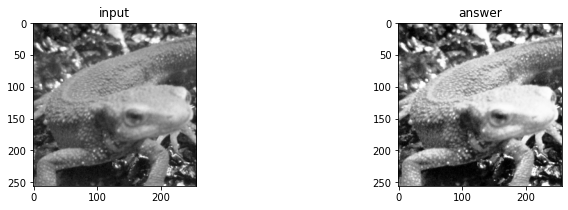

In [15]:
# グレースケール だと若干明るくなった？
img_dark_gray_hist_equ = hist_equ(img_dark_gray)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1); plt.title('input'); plt.imshow(img_dark_gray, cmap='gray')
plt.subplot(1, 2, 2); plt.title('answer'); plt.imshow(img_dark_gray_hist_equ, cmap='gray')
plt.show()

In [16]:
# RGB でやるなら、 RGBそれぞれでやるべきか？
def hist_equ_rgb(img):
    out = np.zeros_like(img, dtype=np.float32)

    s = img.shape[0] * img.shape[1]
    x_max = 255

    for c in range(3):
        h = 0

        for i in range(256):
            h += (img[..., c] == i).sum()
            out[..., c][img[..., c] == i] = x_max / s * h

    return np.clip(out, 0, 255).astype(np.uint8)

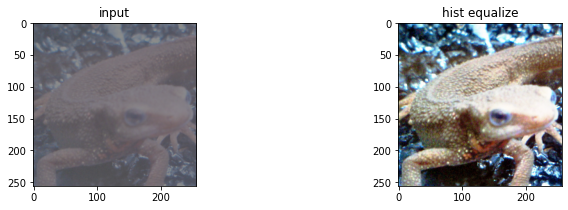

In [17]:
# RGBだと画像がめっちゃきれいになる
img_dark_hist_equ = hist_equ_rgb(img_dark)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1); plt.title('input'); plt.imshow(img_dark)
plt.subplot(1, 2, 2); plt.title('hist equalize'); plt.imshow(img_dark_hist_equ)
plt.show()

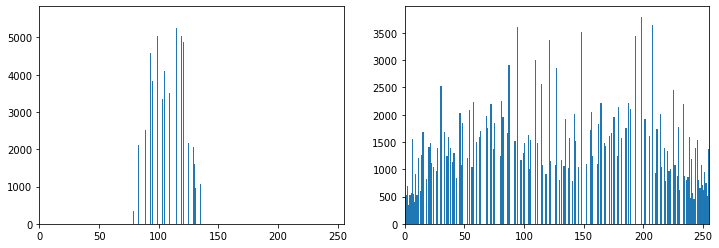

In [18]:
# histogram をみると画素が分散した
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255); plt.xlim([0, 255])
plt.subplot(1, 2, 2); plt.hist(img_dark_hist_equ.ravel(), bins=255); plt.xlim([0, 255])
plt.show()

In [19]:
# RGB でやるなら、 RGBを一括でやるべきか？
def hist_equ_rgb_2(img):
    out = np.zeros_like(img, dtype=np.float32)

    s = img.size
    x_max = 255

    h = 0

    for i in range(256):
        h += (img == i).sum()
        out[img == i] = x_max / s * h

    return np.clip(out, 0, 255).astype(np.uint8)

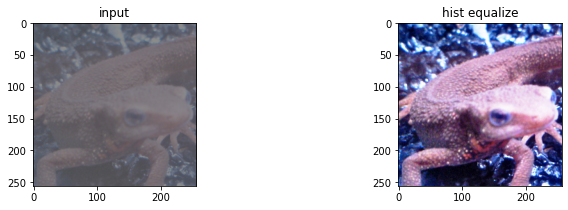

In [20]:
# RGBだと画像がめっちゃきれいになる
img_dark_hist_equ_2 = hist_equ_rgb_2(img_dark)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1); plt.title('input'); plt.imshow(img_dark)
plt.subplot(1, 2, 2); plt.title('hist equalize'); plt.imshow(img_dark_hist_equ_2)
plt.show()

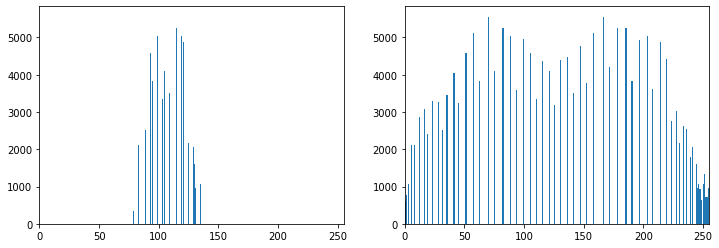

In [21]:
# histogram をみると画素が分散した
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255); plt.xlim([0, 255])
plt.subplot(1, 2, 2); plt.hist(img_dark_hist_equ_2.ravel(), bins=255); plt.xlim([0, 255])
plt.show()

### Q.24 ガンマ補正, Gamma correction

imori_256x256_gamma.jpg に対してガンマ補正(c=1, g=2.2)を実行せよ。

ガンマ補正とは、カメラなどの媒体の経由によって画素値が非線形的に変換された場合の補正である。 ディスプレイなどで画像をそのまま表示すると画面が暗くなってしまうため、RGBの値を予め大きくすることで、ディスプレイの特性を排除した画像表示を行うことがガンマ補正の目的である。

非線形変換は次式で起こるとされる。 ただし xは[0,1] に正規化されている。 c ... 定数、g ... ガンマ特性(通常は2.2)

<img src="https://github.com/TakuroTerui/Gasyori100knock/raw/master/questions/question_21_30/images/gamma_equ.png" width="200"/>

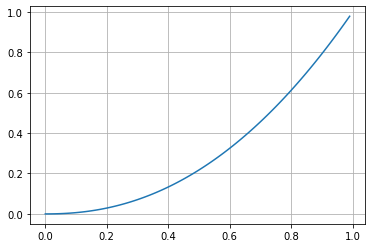

In [22]:
x = np.arange(0, 1, 0.01); plt.plot(x, x ** 2.2); plt.grid(); plt.show()

これを線形に直すために次式の補正を掛ける


これは$ 0 ≦ x ≦ 1 $なので、$ 0 ≦ x ≦ 255 $に逆正規化する必要がある

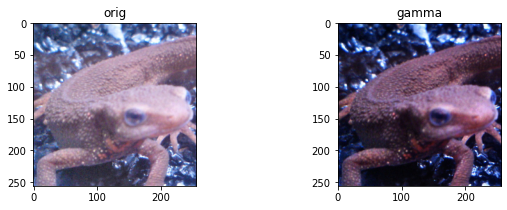

In [23]:
# この位変わるらしい
img_gamma = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_gamma.png')
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1); plt.imshow(img_orig); plt.title('orig')
plt.subplot(1, 2, 2); plt.imshow(img_gamma); plt.title('gamma')
plt.show()

In [24]:
# answer 
def gamma_corr(img, c, g):
    out = (1 / c * (img / 255)) ** (1 / g)
    return np.clip(out * 255, 0, 255).astype(np.uint8)

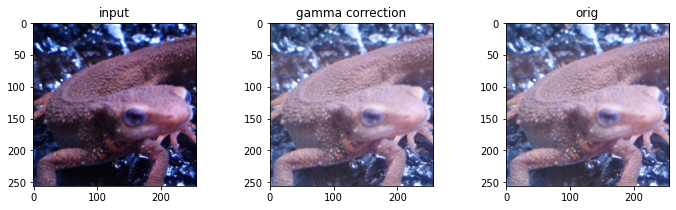

In [25]:
# RGBだと画像がめっちゃきれいになる
img_gamma_corr = gamma_corr(img_gamma, c=1, g=2.2)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img_gamma)
plt.subplot(1, 3, 2); plt.title('gamma correction'); plt.imshow(img_gamma_corr)
plt.subplot(1, 3, 3); plt.title('orig'); plt.imshow(img_orig)
plt.show()

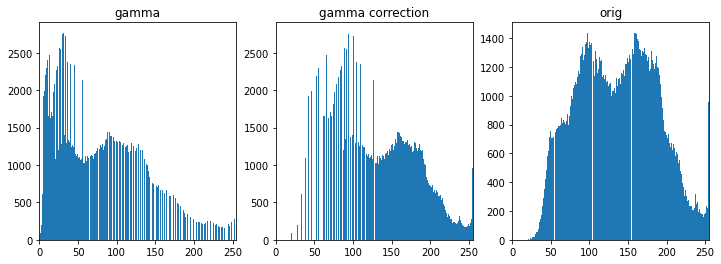

In [26]:
# histogram をみると画素が分散した
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.hist(img_gamma.ravel(), bins=255); plt.xlim([0, 255]); plt.title('gamma')
plt.subplot(1, 3, 2); plt.hist(img_gamma_corr.ravel(), bins=255); plt.xlim([0, 255]); plt.title('gamma correction')
plt.subplot(1, 3, 3); plt.hist(img_orig.ravel(), bins=255); plt.xlim([0, 255]); plt.title('orig')
plt.show()

### Q.25 最近傍補間, Nearest nighbor interpolation (NN法)

最近傍補間により画像を1.5倍に拡大せよ。

最近傍補間(Nearest Neighbor)は画像の拡大時に最近傍にある画素をそのまま使う手法である。 シンプルで処理速度が速いが、画質の劣化は著しい。

画像が縦a倍、横b倍になったとすると、拡大後の画像のx, yはそれぞれ次式となる。拡大後x'の位置のピクセルは元画像のx/aの位置の画素値が当てはまることを意味する。

- y' = round(y / a)
- x' = round(x / a)

In [27]:
# answer
def nn_inter(img, a, b):
    out_h = int(img.shape[0] * a)
    out_w = int(img.shape[1] * b)
    out = np.zeros([out_h, out_w, img.shape[2]], dtype=np.uint8)

    xs, ys = np.meshgrid(range(out_h), range(out_w))
    out[ys, xs] = img[np.round(ys / a).astype(int), np.round(xs / b).astype(int)]
    return out

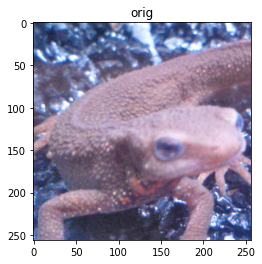

In [28]:
plt.imshow(img_orig); plt.title('orig'); plt.show()

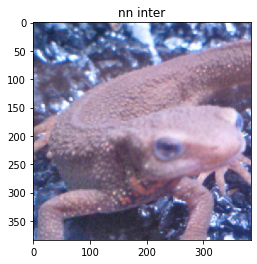

In [32]:
img_nn = nn_inter(img_orig, a=1.5, b=1.5)
plt.imshow(img_nn); plt.title('nn inter'); plt.show()

### Q.26 バイリニア補間, Bi-linear interpolation

### Q.27 Bi-cubic補間

### Q.28 アフィン変換(平行移動), Affine shift

### Q.29 アフィン変換(拡大縮小), Affine scale

### Q.30 アフィン変換(回転), Affine rotation